# Clustering

In [58]:
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial

In [59]:
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

## Creating data

In [60]:
n_clusters=6
n_samples =250

To generate our data, we're going to pick 6 random points, which we'll call centroids, and for each point we're going to generate 250 random points about it.

In [61]:
max(torch.rand(5,))*70

tensor(67.151)

In [87]:
centroids = torch.rand(n_clusters, 2)*70-35

In [63]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [64]:
tensor([1,]).shape

torch.Size([1])

In [65]:
# def sample(m): return MultivariateNormal(m,torch.diag(tensor([5.,5]))).sample(n_samples)
MultivariateNormal.sample?

Signature: MultivariateNormal.sample(self, sample_shape: torch.Size = torch.Size([])) -> torch.Tensor
Docstring:
Generates a sample_shape shaped sample or sample_shape shaped batch of
samples if the distribution parameters are batched.
File:      /opt/conda/lib/python3.10/site-packages/torch/distributions/distribution.py
Type:      function

In [66]:
def sample(m): return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))

In [67]:
slices = [sample(c) for c in centroids]
data = torch.cat(slices)
data.shape # 250*6 = 1500

torch.Size([1500, 2])

Below we can see each centroid marked X

In [68]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: _,ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker="x", color='k', mew=6)
        ax.plot(*centroid, markersize=5, marker="x", color='m', mew=2)

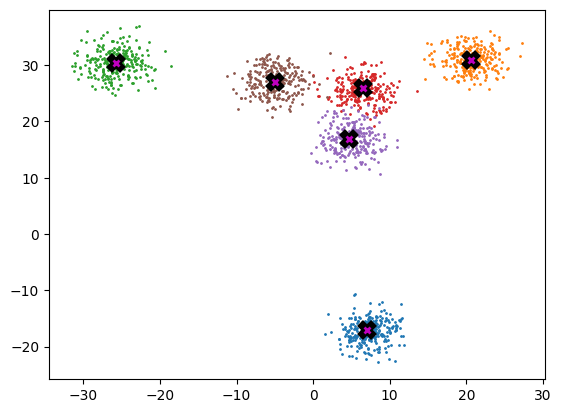

In [86]:
plot_data(centroids, data, n_samples)

In [70]:
def gaussian(d, bw): return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

In [71]:
def plot_func(f):
    x = torch.linspace(0,10,100)
    plt.plot(x, f(x))

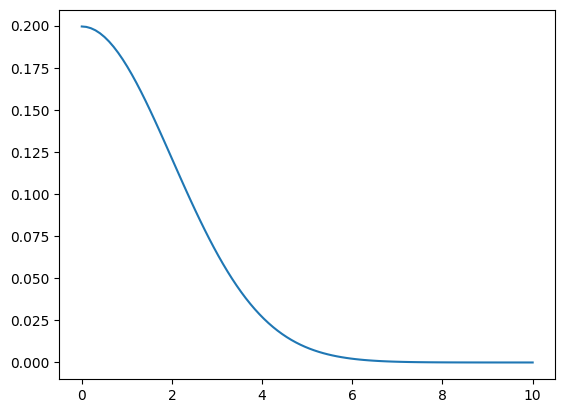

In [72]:
plot_func(partial(gaussian, bw=2.0)) #lesser bw due to closer clusters, figure this out for that market survey dataset for work QUICKK!!

In [73]:
partial

functools.partial

In our implementation, we choose the bandwidth to be 2.0( this is taken typically to cover around 40% of data


In [74]:
# def tri(d, i): return (-d+i).clamp_min(0)/i

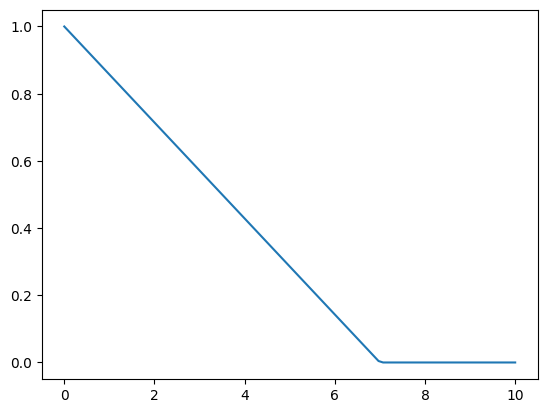

In [75]:
plot_func(partial(tri, i=7))

In [76]:
X = data.clone()
x = data[0]  # just the first data sample
data.shape

torch.Size([1500, 2])

In [77]:
x

tensor([  6.706, -18.152])

In [78]:
x.shape,X.shape,x[None].shape

(torch.Size([2]), torch.Size([1500, 2]), torch.Size([1, 2]))

In [79]:
(x[None]-X)[:8]

tensor([[ 0.000,  0.000],
        [-1.340,  0.583],
        [-2.768, -2.903],
        [-4.115, -1.908],
        [-3.256, -2.477],
        [-3.341, -0.594],
        [-0.450, -0.550],
        [-2.280, -0.420]])

In [80]:
(x-X)[:8] # broadcasting 

tensor([[ 0.000,  0.000],
        [-1.340,  0.583],
        [-2.768, -2.903],
        [-4.115, -1.908],
        [-3.256, -2.477],
        [-3.341, -0.594],
        [-0.450, -0.550],
        [-2.280, -0.420]])

In [81]:

dist = ((x-X)**2).sum(1).sqrt()
dist[:8]
dist.shape

torch.Size([1500])

In [82]:
weight = gaussian(dist, 2.5) # sampling from a Gaussian, aweight for each and every point
weight.shape

torch.Size([1500])

In [83]:
weight.shape,X.shape

(torch.Size([1500]), torch.Size([1500, 2]))

In [84]:
weight*X #will throw error for dim mismatch

RuntimeError: The size of tensor a (1500) must match the size of tensor b (2) at non-singleton dimension 1

In [ ]:
weight[:,None].shape

In [ ]:
weight[:,None]*X

In [ ]:
def one_update(X):
    for i, x in enumerate(X):
        dist = torch.sqrt(((x-X)**2).sum(1))
        weight = gaussian(dist, 2.0)
#         weight = tri(dist, 8)
        X[i] = (weight[:,None]*X).sum(0)/weight.sum()

In [ ]:
def meanshift(data):
    X = data.clone()
    for it in range(5): one_update(X)
    return X

In [ ]:
%time X=meanshift(data)

In [ ]:
plot_data(centroids+2, X, n_samples) #DATA CLUSTERED

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [ ]:
def do_one(d):
    if d: one_update(X)
    ax.clear()
    plot_data(centroids+2, X, n_samples, ax=ax)

In [88]:

X = data.clone()
fig,ax = plt.subplots()
ani = FuncAnimation(fig, do_one, frames=5, interval=500, repeat=False)
plt.close()
HTML(ani.to_jshtml())

## GPU batched algorithm

To truly accelerate the algorithm, we need to be performing updates on a batch of points per iteration, instead of just one as we were doing.

In [37]:
bs=5
X = data.clone()
x = X[:bs]
x.shape,X.shape

(torch.Size([5, 2]), torch.Size([1500, 2]))

In [38]:
X[None,:].shape, x[:,None].shape, (X[None,:]-x[:,None]).shape

(torch.Size([1, 1500, 2]), torch.Size([5, 1, 2]), torch.Size([5, 1500, 2]))

In [39]:
def dist_b(a,b): return (((a[None]-b[:,None])**2).sum(2)).sqrt() #following broadcasting compatibility rules

In [40]:
dist_b(X, x)

tensor([[ 0.000,  1.461,  4.011,  ..., 48.716, 46.274, 48.519],
        [ 1.461,  0.000,  3.767,  ..., 49.645, 47.110, 49.429],
        [ 4.011,  3.767,  0.000,  ..., 46.775, 44.052, 46.518],
        [ 4.536,  3.729,  1.674,  ..., 48.172, 45.371, 47.899],
        [ 4.091,  3.611,  0.647,  ..., 47.340, 44.590, 47.077]])

In [41]:
dist_b(X, x).shape

torch.Size([5, 1500])

In [42]:
weight = gaussian(dist_b(X, x), 2)
weight

tensor([[0.199, 0.153, 0.027,  ..., 0.000, 0.000, 0.000],
        [0.153, 0.199, 0.034,  ..., 0.000, 0.000, 0.000],
        [0.027, 0.034, 0.199,  ..., 0.000, 0.000, 0.000],
        [0.015, 0.035, 0.140,  ..., 0.000, 0.000, 0.000],
        [0.025, 0.039, 0.189,  ..., 0.000, 0.000, 0.000]])

In [43]:
weight.shape,X.shape

(torch.Size([5, 1500]), torch.Size([1500, 2]))

In [44]:
weight[...,None].shape, X[None].shape # for multiplication

(torch.Size([5, 1500, 1]), torch.Size([1, 1500, 2]))

In [45]:
num = (weight[...,None]*X[None]).sum(1)
num.shape

torch.Size([5, 2])

In [46]:
num

tensor([[ 153.615, -395.688],
        [ 148.430, -351.879],
        [ 128.085, -240.969],
        [ 106.127, -189.512],
        [ 126.282, -233.361]])

In [47]:
 weight@X # matrix multiply through broadcasting!!

tensor([[ 153.615, -395.687],
        [ 148.430, -351.879],
        [ 128.085, -240.969],
        [ 106.127, -189.512],
        [ 126.282, -233.361]])

In [48]:
div = weight.sum(1, keepdim=True)
div.shape

torch.Size([5, 1])

In [49]:
num/div

tensor([[  6.890, -17.747],
        [  7.588, -17.989],
        [  8.574, -16.131],
        [  9.263, -16.541],
        [  8.827, -16.311]])

In [50]:
def meanshift(data, bs=500):
    n = len(data)
    X = data.clone()
    for it in range(5):
        for i in range(0, n, bs):
            s = slice(i, min(i+bs,n))
            weight = gaussian(dist_b(X, X[s]), 2.5)
#             weight = tri(dist_b(X, X[s]), 8)
            div = weight.sum(1, keepdim=True)
            X[s] = weight@X/div
    return X

Although each iteration still has to launch a new cuda kernel, there are now fewer iterations.

In [51]:
data.shape

torch.Size([1500, 2])

In [52]:
data = data.cuda()

In [53]:
X = meanshift(data).cpu()

In [54]:
%timeit -n 5 _=meanshift(data, 3000).cpu()

6.25 ms ± 106 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


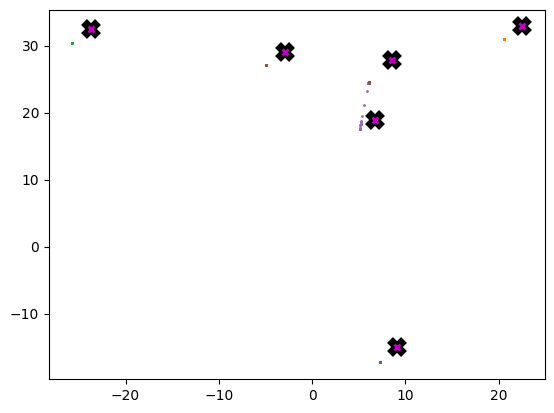

In [55]:
plot_data(centroids+2, X, n_samples)